<a href="https://colab.research.google.com/github/LSJgobsl/TransformerSNP500/blob/main/snp500_with_BCE_LOSS_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_data = pd.read_csv('./drive/MyDrive/graph/GSPC.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date',inplace=True)

goog = pd.read_csv('./drive/MyDrive/graph/GOOG.csv')
goog['Date'] = pd.to_datetime(goog['Date'])
goog.set_index('Date',inplace = True)

amzn = pd.read_csv('./drive/MyDrive/graph/AMZN.csv')
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn.set_index('Date',inplace=True)

fb = pd.read_csv('./drive/MyDrive/graph/FB.csv')
fb['Date'] = pd.to_datetime(fb['Date'])
fb.set_index('Date',inplace = True)

nflx = pd.read_csv('./drive/MyDrive/graph/NFLX.csv')
nflx['Date'] = pd.to_datetime(nflx['Date'])
nflx.set_index('Date',inplace = True)

aapl = pd.read_csv('./drive/MyDrive/graph/AAPL.csv')
aapl['Date'] = pd.to_datetime(aapl['Date'])
aapl.set_index('Date', inplace = True)

msft = pd.read_csv('./drive/MyDrive/graph/MSFT.csv')
msft['Date'] = pd.to_datetime(msft['Date'])
msft.set_index('Date',inplace = True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
date_list =  raw_data.index.to_list()
print(date_list)

In [ ]:
binda = pd.read_csv("./drive/My Drive/Colab Notebooks/glue_data/labeldata.csv")
binda['date'] = pd.to_datetime(binda['date'])
b_date_list = binda['date'].to_list()
print(b_date_list)

In [ ]:
b_list = []
for dates in date_list:
  if dates in b_date_list:
    #print(binda.loc[binda.date == dates])
    b_list.append(binda.loc[binda.date==dates]['label'].item())
  else:
    b_list.append(0)

In [ ]:
print(binda.groupby('UD').size())


UD
0    628
1    629
dtype: int64


In [ ]:
len(b_list)

1258

In [ ]:
bin_df = pd.DataFrame(b_list, columns=['label'])

volume = 주식 거래량 \
open = 장 시작\
close = 장 마감\
high = 장중 최고거래액\
low = 장중 최저거래액

전체 데이터 shape:(1258, 6)
(1258,)
(1258,)
(1258,)
(1258,)


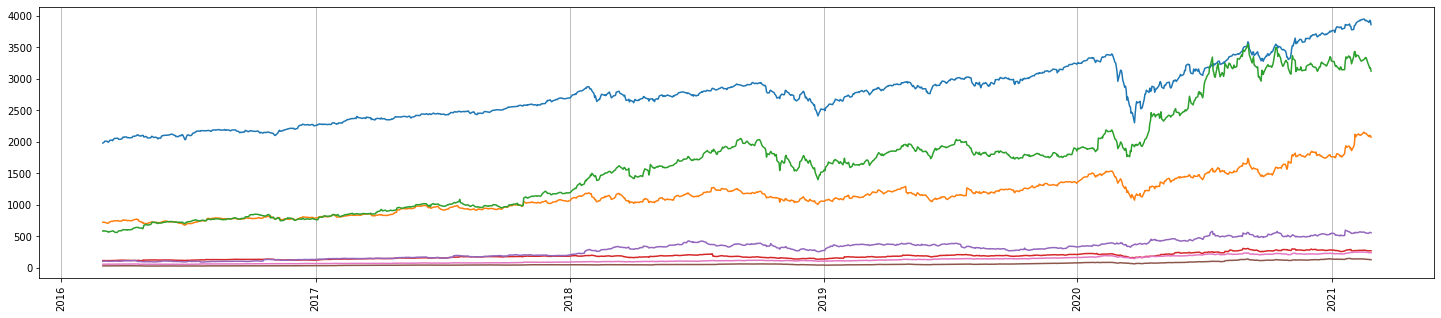

In [ ]:
print("전체 데이터 shape:{}".format(raw_data.shape))
plt.figure(figsize=(25,5))
plt.plot(raw_data['High'],label='SNP500')
plt.plot(goog['High'],label='Google')
plt.plot(amzn['High'], label='Amazon')
plt.plot(fb['High'],label='Facebook')
plt.plot(nflx['High'],label='Netflix')
plt.plot(aapl['High'],label='apple')
plt.plot(msft['High'],label='MicroSoft')

print(fb['High'].shape)
print(nflx['High'].shape)
print(aapl['High'].shape)
print(msft['High'].shape)

plt.xticks(rotation=90)
plt.grid(axis='x')

In [ ]:
output_window = 1
input_window = 15
batch_size = 20
input_dim = 8
d_model = 256
calcualte_loss_over_all_values = False

In [ ]:
def s2frame(ser, sclr, str):
  sertmp = ser.to_frame()
  serscaler = sclr.fit(sertmp.values.reshape(-1,1))
  sers = serscaler.transform(sertmp.values.reshape(-1,1))
  print(type(sers),'\n',sers)
  sertmp = pd.DataFrame(sers, columns = [str])
  return sertmp, serscaler

In [ ]:
X_cols = list(raw_data.columns)
X_cols.remove('High')

test_data_size = int(1258*0.3)
X = raw_data[X_cols]
y = raw_data['High']
real_y = y
y.dropna(inplace=True)
#print(type(y))

scaler = StandardScaler()

y, yscaler = s2frame(y, scaler, 'GSPC')
print(y.index)

<class 'numpy.ndarray'> 
 [[-1.73270375]
 [-1.71453967]
 [-1.69855728]
 ...
 [ 2.60862585]
 [ 2.6005458 ]
 [ 2.45821674]]
RangeIndex(start=0, stop=1258, step=1)


In [ ]:

#print(y, real_y)
#real = yscaler.inverse_transform(y)
#print('IT\'S REAL',real, real_y[-10:])

goog_high = goog['Close']
goog_high.dropna(inplace=True)

g , gscaler = s2frame(goog_high, scaler, 'GOOG')
print(g)

amzn_high = amzn['Close']
amzn_high.dropna(inplace=True)

a , ascaler = s2frame(amzn_high, scaler, 'AMZN')


merged_data = pd.concat([y, a], axis = 1)
#print(merged_data)
merged_data = pd.concat([merged_data, g], axis = 1)
#print(merged_data)

fb_high = fb['Close']
fb_high.dropna(inplace=True)

f, fscaler = s2frame(fb_high, scaler, 'FB')

merged_data = pd.concat([merged_data, f],axis = 1)
#print(merged_data)

nflx_high = nflx['Close']
nflx_high.dropna(inplace=True)

n, nscaler = s2frame(nflx_high, scaler, 'NFLX')

merged_data = pd.concat([merged_data, n], axis  = 1)
#print(merged_data)

aapl_high = aapl['Close']
aapl_high.dropna(inplace=True)

ap, apscaler = s2frame(aapl_high, scaler, 'AAPL')

merged_data = pd.concat([merged_data, ap], axis = 1)

msft_high=msft['Close']
msft_high.dropna(inplace=True)

ms, msscaler = s2frame(msft_high, scaler, 'MSFT')

md = pd.concat([merged_data, ms], axis = 1)
print(md)

md = pd.concat([md, bin_df], axis=1)
print(md)
md = md.to_numpy()
print(md.shape)
yscaler = scaler.fit(real_y.values.reshape(-1,1))
real = yscaler.inverse_transform(y)
#print('IT\'S REAL',real, real_y[-10:])

X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y = y.to_numpy()
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()
md_train, md_test = md[:-test_data_size], md[-test_data_size:]

#print("train set : ",(y_train.shape))
print(md_train.shape)

plt.plot(md)

#y_train

In [ ]:
def updownper(initial, now):
  return 100*(now - initial)/initial
updownper(0.201,0.21)


4.477611940298497

#**seq data 형성함수**
>create sequence 시퀀스를 생성한다 \
 그리고 sequence로 바꾼다.

In [ ]:
2/2*4

4.0

In [ ]:
def UpDownLoss2(output, targets):
  tgt_list = []
  opt_list = []

  for i in range(len(targets)):
    tgt_items = targets[i][-output_window:]
    tgt_yesterday = targets[i][-output_window-1:-output_window]
      #print(tgt_items, '\0',tgt_yesterday)
    out_item = output[i][-output_window:]
    out_yesterday = output[i][-output_window-1:-output_window]
      #print(out_item, '\0',out_yesterday)
    if output_window is 1:
      if (updownper(tgt_yesterday, tgt_items) >= 0):
        tgt_list.append([1])
      else:
        tgt_list.append([0])
      if (updownper(out_yesterday, out_item)>=0):
        opt_list.append([1])
      else:
        opt_list.append([0])
  real = torch.FloatTensor(tgt_list)
  predict = torch.FloatTensor(opt_list)
  m = nn.BCELoss()
  result = m(real,predict)
  return result


In [ ]:
a = [[1,1],[0,1]]
b = [[0,1],[1,0]]
a= torch.FloatTensor(a)
b = torch.FloatTensor(b)
print(torch.abs(a-b))
torch.abs(a-b).mean()



tensor([[1., 0.],
        [1., 1.]])


tensor(0.7500)

In [ ]:
#mdl = input("사용 Model\n 1:Transformer 2:LSTM: ")
mdl = 1
mdl = int(mdl)

In [ ]:
def create_sequences1(array, tw):
  res = []
  L = len(array)
  for i in range(L - tw ):
    #print(len(array[i:i+tw]))
    tr_seq = array[i:i + tw]
    #print(tr_seq)
    train_label = array[i+output_window:i+output_window + tw]
    res.append((tr_seq, train_label))
  return torch.FloatTensor(res)

In [ ]:
def create_sequences2(array,array2, tw):
  input = []
  output = []

  for i in range(len(array)-tw-1):
    tmp = array[i:i+tw]
    input.append(tmp)

    tmp2 = array2[i+tw-1: i+1+tw]
    #print(tmp2)
    if (updownper(tmp2[0], tmp2[1]) >=0):
      output.append([1])
    else:
      output.append([0])
  return torch.FloatTensor(input), torch.FloatTensor(output)

In [ ]:
print(md_train.shape, y_train.shape)

(881, 8) (881,)


In [ ]:
seq_len = input_window
#X_train = create_sequences1(X_train, seq_len)
y_train_seq = create_sequences1(y_train, seq_len)
#X_test = create_sequences1(X_test, seq_len)
y_test_seq = create_sequences1(y_test, seq_len)

md_train_seq = create_sequences1(md_train, input_window)
md_test_seq = create_sequences1(md_test, input_window)

lstm_md_train, lstm_tgt_train= create_sequences2(md_train,y_train,input_window)
lstm_md_test, lstm_tgt_test = create_sequences2(md_test, y_test, input_window)

tf_input_train, tf_output_train = create_sequences2(md_train,y_train,input_window)
tf_input_test, tf_output_test = create_sequences2(md_test, y_test, input_window)

y_train_seq = y_train_seq[:-output_window]
y_test_seq = y_test_seq[:-output_window]
print(y_train_seq.shape)
print(md_train.shape)
print(tf_input_train.shape)
print(lstm_tgt_test.shape)
print(tf_output_train.shape)
len(tf_output_test)


torch.Size([865, 2, 15])
(881, 8)
torch.Size([865, 15, 8])
torch.Size([361, 1])
torch.Size([865, 1])


361

In [ ]:
def create_sequences3(array,array2, tw): #for saving train,
  input = []
  output = []
  ar2 = yscaler.inverse_transform(array2)
  for i in range(len(array)-tw-1):
    tmp = array[i:i+tw+1]
    input.append(tmp)
    
    tmp2 = ar2[i+tw-1: i+1+tw]
    #print(tmp2)
    if (updownper(tmp2[0], tmp2[1]) >=0.065):
      output.append([1])
    else:
      output.append([0])
  return torch.FloatTensor(input), torch.FloatTensor(output)

In [ ]:
from sklearn.model_selection import train_test_split

#itrain, itest, otrain, otest = train_test_split(ip, op, stratify=op, test_size = 0.2, random_state=0)

In [ ]:
tf_in_tr, tf_out_tr = create_sequences3(md_train,y_train,input_window)
tf_in_t, tf_out_t = create_sequences3(md_test, y_test, input_window)

In [ ]:
tfin = np.concatenate((tf_in_tr, tf_in_t))
tfo = np.concatenate((tf_out_tr, tf_out_t))

In [ ]:
npin_train, npin_test, npo_train, npo_test = train_test_split(tfin, tfo, stratify=tfo, test_size = 0.2, random_state=0)

In [ ]:

np.save('./drive/MyDrive/graph/npo_train_with_doc.npy',npo_train )

np.save('./drive/MyDrive/graph/npo_test_with_doc.npy', npo_test)

np.save('./drive/MyDrive/graph/npin_train_with_doc.npy', npin_train)

np.save('./drive/MyDrive/graph/npin_test_with_doc.npy', npin_test)


In [ ]:
tot = np.load('./drive/MyDrive/graph/npo_train_with_doc.npy')

totgt = np.load('./drive/MyDrive/graph/npo_test_with_doc.npy')

tit = np.load('./drive/MyDrive/graph/npin_train_with_doc.npy')

titgt = np.load('./drive/MyDrive/graph/npin_test_with_doc.npy')


print(np.unique(tot, return_counts=True))
print(np.unique(totgt, return_counts=True))

op = np.concatenate((tot, totgt))
ip = np.concatenate((tit, titgt))

print(ip.shape)
print(np.unique(op, return_counts = True))

(array([0., 1.], dtype=float32), array([492, 488]))
(array([0., 1.], dtype=float32), array([124, 122]))
(1226, 16, 8)
(array([0., 1.], dtype=float32), array([616, 610]))


In [ ]:
tf_output_test = torch.from_numpy(np.load('./drive/MyDrive/graph/npo_test_with_doc.npy'))
tf_output_train = torch.from_numpy(np.load('./drive/MyDrive/graph/npo_train_with_doc.npy'))
tf_input_test = torch.from_numpy(np.load('./drive/MyDrive/graph/npin_test_with_doc.npy'))
tf_input_train = torch.from_numpy(np.load('./drive/MyDrive/graph/npin_train_with_doc.npy'))

In [ ]:
tf_input_train = torch.stack([secdim[0:-1] for secdim in tf_input_train])
tf_input_test= torch.stack([secdim[0:-1] for secdim in tf_input_test])

In [ ]:

tf_input_train_2d = tf_input_train.reshape(tf_input_train.shape[0],1, -1)
tf_input_test_2d = tf_input_test.reshape(tf_input_test.shape[0], 1, -1)


y_train_seq = y_train_seq[:-output_window]
y_test_seq = y_test_seq[:-output_window]
tf_input_test.shape
print(tf_input_train_2d.shape)
#print(tf_input_train)
#print(tf_input_train_2d)

torch.Size([980, 1, 120])


In [ ]:
yscaler.inverse_transform(y)

>예시


예시의 create_inout_sequences 역할과 비슷

In [ ]:
#print("X_train :",(X_train.shape))
#print("X_test :",(X_test.shape))
#print("y_train :",(y_train_seq.shape))
#print("y_test :",(y_test_seq.shape))

**LSTM**

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout = 0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0,1)
    self.register_buffer('pe',pe)
  
  def forward(self,x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

**MODEL 정의하기**
**Transformer**

In [ ]:
class TransformerModel(nn.Module):

  def __init__(self, ninp = d_model, nlayers=2, dropout=0.2):
    super(TransformerModel, self).__init__()

    from torch.nn import TransformerEncoder, TransformerEncoderLayer
    
    self.model_type = 'Transformer'
    
    self.src_mask = None
    
    self.ninp = ninp
    self.encoder = nn.Linear(8,ninp)
    self.pos_encoder = PositionalEncoding(ninp)

    self.encoder_layers = TransformerEncoderLayer(d_model = ninp, nhead = 8, dim_feedforward=1024, dropout = dropout)
    self.transformer_encoder = TransformerEncoder(self.encoder_layers, num_layers = nlayers)
   # self.encoder = nn.Embedding(1, ninp) #시계열에서 불필요?
    self.decoder = nn.Linear(ninp, 1)
    self.seq2label = nn.Linear(input_window,1)
    self.sig = nn.Sigmoid()
    self.agge = nn.Linear(ninp*input_window,1)

    self.init_weights()

  def _generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def init_weights(self):
    initrange = 0.1
    self.encoder.weight.data.uniform_(-initrange,initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

  def forward(self, src):
    #print("====================================")
    #print(src.shape)
    if self.src_mask is None or self.src_mask.size(0) != len(src):
      device = src.device
      mask = self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask = mask
    #print("before encoder:",src.shape, "src_mask shape:", self.src_mask.shape)
    src = self.encoder(src)
    #print(src)
    #print("after encoder:",src.shape)
    src = self.pos_encoder(src)
    output = self.transformer_encoder(src, self.src_mask)
    #output = self.decoder(output)
    
    #output = self.seq2label(output.view(-1, input_window))
    output = self.agge(output.view(len(output),-1))
    #print(output)
    #output = self.sig(output)
    return output

In [ ]:
class LSTMmodel(nn.Module):
  def __init__(self,n_features, n_hidden, seq_len, n_layers=2):
    super(LSTMmodel, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len=seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(input_size=n_features, hidden_size= n_hidden, num_layers=n_layers)
    self.linear = nn.Linear(in_features=n_hidden, out_features = 1)
  
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    print(sequences.shape)
    lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
    print(lstm_out.shape)
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    print(last_time_step.shape)
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:
ex_model = LSTMmodel(n_features=8, n_hidden=64, seq_len=input_window, n_layers=4)

In [ ]:
tf_input_train.shape

torch.Size([980, 15, 8])

In [ ]:
ex_model.reset_hidden_state()

In [ ]:
outs = ex_model(tf_input_train)

In [ ]:
outs.shape

torch.Size([980, 1])

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
'''
model1 = TransformerModel()
model1
'''

'\nmodel1 = TransformerModel()\nmodel1\n'

In [ ]:
lin = nn.Linear(7,1)
a = torch.randn(3,7)
a.shape
lin(a)

In [ ]:
a=torch.Tensor([1,2])
b=torch.Tensor([3,4])
c=torch.Tensor([5,6])
torch.stack([a,b,c]).chunk(3,1)

d = torch.Tensor([[[1,2],[3,4]],[[5,6],[7,8]],[[9,10],[11,12]]])
print(d.shape[0])
d.reshape(d.shape[0],-1)

In [ ]:
def get_batch(source, target, i, batch_size):
  #print(batch_size)
  length = min(batch_size, len(source) - 1 - i)
  #print(length)
  #print(data.shape)
  input = source[i:i+length]
  output = target[i:i+length]
  return input, output

In [ ]:
print(tf_input_train.shape)
print(tf_output_train.shape)
inp, oup = get_batch(tf_input_train,tf_output_train, 0 , batch_size)

print("inp shpae:",inp.shape)
print(oup.shape)
print(tf_input_test_2d.shape, tf_output_test.shape)

torch.Size([980, 15, 8])
torch.Size([980, 1])
inp shpae: torch.Size([20, 15, 8])
torch.Size([20, 1])
torch.Size([246, 1, 120]) torch.Size([246, 1])


inp shape 의 40, 15, 7 에서 7개의 feature들을 하나로 묶을 필요 있음

In [ ]:
a = torch.Tensor([[1,2,3,4],[5,6,7,8]])
a.shape

torch.Size([2, 4])

#**Train 생성하기**


In [ ]:
import os
def createDirectory(directory):
  try:
    if not os.path.exists(directory):
      os.makedirs(directory)
  except OSError:
    print("failed")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [ ]:

def MPE(test, pred):

  #test, pred = check_array

  return torch.mean((test - pred) / test)*100

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import sklearn.dummy

In [ ]:
sample = tf_output_test.numpy()
print(sample.shape)
ze = np.zeros((len(sample),1))
print(ze.shape)
on = np.ones((len(sample),1))
f1_z = f1_score(sample, ze)
f1_o = f1_score(sample, on)
print("f1_score with dummy zero:{0}\nf1_score with dummy ones:{1}".format(f1_z, f1_o))
sample = sample.flatten()
ze = ze.flatten()
on = on.flatten()
f1_z = f1_score(sample, ze)
f1_o = f1_score(sample, on)
acc_o = accuracy_score(sample, on)
print("f1_score with dummy zero:{0}\nf1_score with dummy ones:{1}\nacc score:{2}".format(f1_z, f1_o, acc_o))
np.unique(sample, return_counts=True)


(246, 1)
(246, 1)
f1_score with dummy zero:0.0
f1_score with dummy ones:0.6630434782608696
f1_score with dummy zero:0.0
f1_score with dummy ones:0.6630434782608696
acc score:0.4959349593495935


(array([0., 1.], dtype=float32), array([124, 122]))

In [ ]:
dumb = sklearn.dummy.DummyClassifier(strategy='uniform')

In [ ]:
def plot_and_loss(eval_model, data_source, data_output, epoch):
  eval_model.eval()
  total_loss = 0.
  target_list = []
  output_list = []
  with torch.no_grad():
    for i in range(0,len(data_source)-1):
      data, target = get_batch(data_source, data_output, i, 1)
      
      output = eval_model(data)
      target_list.append([target.item()])
      output_list.append([output.item()])
  #bce = nn.BCELoss()
  target_list = torch.Tensor(target_list)
  output_list = torch.Tensor(output_list)
  print(output_list.shape)
  sig = nn.Sigmoid()
  sigged_output = output_list
  #print(target_list,"\n",sigged_output)

  #print(np_result.shape)
  #print(truth_nn, result_nn)
  bce = nn.BCEWithLogitsLoss()
  
  #print(np_result, np_truth)
  nn_mse = nn.MSELoss()

  UD_score = bce(target_list, output_list)
  #print(type(UD_score))
  tnp = target_list.numpy()
  sop = output_list.numpy()
  #print (tnp, sop)
  sop = np.where(sop >= 0.5, 1, 0)

  #print(sop.shape, tnp.shape)
  f1 = f1_score(tnp, sop)
  acc = accuracy_score(tnp, sop)
  print("BCE_LOSS:", UD_score)
  print("F1_score:", f1)
  print("accuracy:", acc)
  idx = range(0, len(data_source))
  return UD_score.item(), f1, acc

In [ ]:
def train(train_data, train_output):
  
  model.train() #학습모드 시작
  total_loss = 0. #total loss 초기화
  start_time = time.time() 
  
  for batch, i in enumerate(range(0, len(train_data) - 1,batch_size)):
    
    data, targets = get_batch(train_data,train_output, i, batch_size)
    #print(data.shape, targets.shape)
    optimizer.zero_grad()
    
    output = model(data)
    #print(output, targets)
    loss = criterion(output, targets)
    #loss.requires_grad = True
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
    optimizer.step()

    total_loss += loss.item()
    log_interval = int(len(train_data) / batch_size)
    if batch % log_interval == 0 and batch > 0:
      cur_loss = total_loss / log_interval
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | '
        'loss {:5.5f} '.format
        (epoch, batch, len(train_data) // batch_size,
        elapsed*1000 / log_interval,
        cur_loss))
      total_loss = 0
      start_time = time.time()

**LSTM training**

In [ ]:
#from pandas import DataFrame
model = 0
if mdl is 1:
  print('TF Model Selected')
  model = TransformerModel().to(device)
else:
  model = LSTMModel(n_features = 7, n_hidden = 256, seq_len = input_window, n_layers = 4).to(device)
if mdl is 1:
  train_data = tf_input_train.to(device)
  train_tgt = tf_output_train.to(device)
  test_data = tf_input_test.to(device)
  test_tgt = tf_output_test.to(device)
else: # 따로 분리됨 작업 필요
  tr_data = lstm_md_train.to(device)
  tr_tgt = lstm_tgt_train.to(device)
  tst_data = lstm_md_test.to(device)
  tst_tgt = lstm_tgt_test.to(device)
#train_data, val_data = get_data()

criterion = nn.BCEWithLogitsLoss()
#criterion = UpDownLoss()
#criterion = nn.MSELoss()
lr = 2e-05
#optimizer= torch.optim.SGD(model.parameters(), lr = lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.995)

best_val_loss = float("inf")
epochs = 1000
best_model = None

loss_data = {'epoch':[0], 'UpDownLoss':[0], 'MSE':[0], 'RMSE':[0]}
df = pd.DataFrame(loss_data, columns =["epoch","R^2", "MSE", "RMSE"])

if mdl is 1: #transformer
  for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data, train_tgt)
    if epoch % 1 is 0:
      ud, mse_, accu = plot_and_loss(model, test_data, test_tgt, epoch)
      print("||BCE Loss:{0}||f1 score:{1}||accuracy:{2}".format(ud, mse_, accu))
      tmp = [(epoch, ud, mse_, accu)]
      new_data = pd.DataFrame(tmp, columns=df.columns)
      df = df.append(new_data)
    val_loss = 0 
    #predict(model, test_data, test_tgt, 50, epoch)
    try:
       ppl = math.exp(val_loss)
    except OverflowError:
      ppl = float('inf')

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                          val_loss, ppl))
    print('-' * 89)
    #scheduler.step()
  df = df.set_index('epoch')
  df.to_csv('./drive/MyDrive/graph/TF_IW{0}_BS{1}_lr{2}_3try.csv'.format(input_window, batch_size, lr))

else: #LSTM
  model, train_hist, test_hist = train_lstm(model, tr_data, tr_tgt, tst_data, tst_tgt, num_epochs = 300, lr = 0.001)
  #df.to_csv('./drive/MyDrive/graph/TF_IW{0}_BS{1}_lr{2}_short.csv'.format(input_window, ))
  

<details>
<summary>LSTM Model</summary>
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -2.670065156861933
MSE score: 1.7842655528206248
RMSE SCORE: 1.3357640333609169
Epoch 1 train loss: 0.6591 test loss: 1.5446
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -5.808259282750389
MSE score: 3.309952819276273
RMSE SCORE: 1.8193275733842635
Epoch 6 train loss: 0.4676 test loss: 2.6725
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -4.464899359842625
MSE score: 2.6568551948369414
RMSE SCORE: 1.6299862560270075
Epoch 11 train loss: 0.4337 test loss: 2.2639
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -4.4999359724893315
MSE score: 2.673888849107671
RMSE SCORE: 1.6352029993574715
Epoch 16 train loss: 0.432 test loss: 2.2756
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -5.147973604165913
MSE score: 2.9889435344366495
RMSE SCORE: 1.7288561346846214
Epoch 21 train loss: 0.4265 test loss: 2.4785
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -4.929479781177164
MSE score: 2.8827189893127003
RMSE SCORE: 1.6978571757697114
Epoch 26 train loss: 0.4228 test loss: 2.3738
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -4.539523928058235
MSE score: 2.693135217335254
RMSE SCORE: 1.6410774562266262
Epoch 31 train loss: 0.4234 test loss: 2.2142
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -4.568496339786166
MSE score: 2.707220655609185
RMSE SCORE: 1.6453633810223154
Epoch 36 train loss: 0.42 test loss: 2.1765
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -4.556062486425593
MSE score: 2.7011757230829567
RMSE SCORE: 1.6435253947179997
Epoch 41 train loss: 0.4178 test loss: 2.0956
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -4.1225701448628636
MSE score: 2.4904259354352414
RMSE SCORE: 1.578108340842048
Epoch 46 train loss: 0.4123 test loss: 1.9031
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.797894679726345
MSE score: 2.332579351375018
RMSE SCORE: 1.527278413183077
Epoch 51 train loss: 0.4007 test loss: 1.684
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.1013811361574017
MSE score: 1.993957264369426
RMSE SCORE: 1.4120755165250285
Epoch 56 train loss: 0.3796 test loss: 1.3715
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -2.3762128636896502
MSE score: 1.6414041860832125
RMSE SCORE: 1.281172972741469
Epoch 61 train loss: 0.4374 test loss: 1.2279
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -2.8136589286836844
MSE score: 1.854076144652244
RMSE SCORE: 1.3616446469810852
Epoch 66 train loss: 0.418 test loss: 1.3794
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.2395438046657805
MSE score: 2.0611274315378094
RMSE SCORE: 1.4356627151033106
Epoch 71 train loss: 0.3998 test loss: 1.4614
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.493989323526627
MSE score: 2.184830514444699
RMSE SCORE: 1.4781172194534165
Epoch 76 train loss: 0.4061 test loss: 1.4717
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.488606785703605
MSE score: 2.1822137007332545
RMSE SCORE: 1.477231769470605
Epoch 81 train loss: 0.4047 test loss: 1.4667
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.3740231472390754
MSE score: 2.1265068861970446
RMSE SCORE: 1.4582547398164165
Epoch 86 train loss: 0.4023 test loss: 1.451
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.2629334363169322
MSE score: 2.072498704870732
RMSE SCORE: 1.4396175550717392
Epoch 91 train loss: 0.4005 test loss: 1.4171
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.1589297941916596
MSE score: 2.0219355382563613
RMSE SCORE: 1.4219477973035302
Epoch 96 train loss: 0.3965 test loss: 1.3569
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -3.0592059224425965
MSE score: 1.9734530559159396
RMSE SCORE: 1.4047964464348348
Epoch 101 train loss: 0.3932 test loss: 1.2846
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -2.891163811530547
MSE score: 1.891756481847483
RMSE SCORE: 1.3754113864031674
Epoch 106 train loss: 0.385 test loss: 1.2025
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -2.6270677820585644
MSE score: 1.7633616365563791
RMSE SCORE: 1.3279162761847523
Epoch 111 train loss: 0.3733 test loss: 1.1193
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -2.3248460319921964
MSE score: 1.6164313138212747
RMSE SCORE: 1.2713895208869996
Epoch 116 train loss: 0.3581 test loss: 1.0104
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.9258692784699458
MSE score: 1.422461875334617
RMSE SCORE: 1.1926700613894092
Epoch 121 train loss: 0.3386 test loss: 0.8824
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.6400010572903145
MSE score: 1.2834821030700148
RMSE SCORE: 1.1329086914089832
Epoch 126 train loss: 0.3255 test loss: 0.762
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.4631460077109533
MSE score: 1.1975009666815117
RMSE SCORE: 1.094303873099932
Epoch 131 train loss: 0.2999 test loss: 0.6757
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.214410281032006
MSE score: 1.076573797843853
RMSE SCORE: 1.0375807428069648
Epoch 136 train loss: 0.2829 test loss: 0.5677
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -0.9416684802218735
MSE score: 0.9439756615165172
RMSE SCORE: 0.9715840990447081
Epoch 141 train loss: 0.2757 test loss: 0.4851
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -0.8097301553895655
MSE score: 0.8798315665118297
RMSE SCORE: 0.9379933723176458
Epoch 146 train loss: 0.2596 test loss: 0.4683
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -0.8431787264233437
MSE score: 0.8960931669292114
RMSE SCORE: 0.9466219767833469
Epoch 151 train loss: 0.2487 test loss: 0.4678
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -0.8412979309556252
MSE score: 0.8951787857339139
RMSE SCORE: 0.9461388828992886
Epoch 156 train loss: 0.235 test loss: 0.4768
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -0.7119629609866389
MSE score: 0.8323003566522708
RMSE SCORE: 0.9123049691042304
Epoch 161 train loss: 0.276 test loss: 0.4808
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -0.8794522604431363
MSE score: 0.9137281718853422
RMSE SCORE: 0.9558912971072298
Epoch 166 train loss: 0.2436 test loss: 0.517
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -0.9507823131312865
MSE score: 0.9484065087683772
RMSE SCORE: 0.9738616476524666
Epoch 171 train loss: 0.2348 test loss: 0.5405
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0389566463051603
MSE score: 0.9912739834863445
RMSE SCORE: 0.9956274320680123
Epoch 176 train loss: 0.2234 test loss: 0.5565
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.1251817808164608
MSE score: 1.0331938216146097
RMSE SCORE: 1.016461421606649
Epoch 181 train loss: 0.2248 test loss: 0.5505
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0737633347838824
MSE score: 1.0081958561523447
RMSE SCORE: 1.0040895658019482
Epoch 186 train loss: 0.2172 test loss: 0.5424
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0196810310184299
MSE score: 0.9819028102522042
RMSE SCORE: 0.9909100919115741
Epoch 191 train loss: 0.2152 test loss: 0.5286
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.052207712350465
MSE score: 0.9977162180713578
RMSE SCORE: 0.998857456332663
Epoch 196 train loss: 0.2137 test loss: 0.5222
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0891654258139147
MSE score: 1.0156838486788295
RMSE SCORE: 1.0078114152354247
Epoch 201 train loss: 0.2117 test loss: 0.5219
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0793486108949395
MSE score: 1.0109112345835203
RMSE SCORE: 1.0054408160521038
Epoch 206 train loss: 0.2112 test loss: 0.5164
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0783247844924242
MSE score: 1.0104134836979097
RMSE SCORE: 1.00519325689039
Epoch 211 train loss: 0.2125 test loss: 0.516
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0980830604528786
MSE score: 1.0200193107534452
RMSE SCORE: 1.0099600540384976
Epoch 216 train loss: 0.2105 test loss: 0.5206
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0533351332288952
MSE score: 0.9982643332003637
RMSE SCORE: 0.9991317897056242
Epoch 221 train loss: 0.2144 test loss: 0.5229
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0790582883671118
MSE score: 1.0107700892731593
RMSE SCORE: 1.0053706228417256
Epoch 226 train loss: 0.213 test loss: 0.5204
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.1218838496230896
MSE score: 1.031590475414365
RMSE SCORE: 1.0156724252505651
Epoch 231 train loss: 0.2125 test loss: 0.528
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0681067006129528
MSE score: 1.00544578576811
RMSE SCORE: 1.0027191958709627
Epoch 236 train loss: 0.2145 test loss: 0.5347
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0231496225937327
MSE score: 0.9835891259441871
RMSE SCORE: 0.9917606192747256
Epoch 241 train loss: 0.2117 test loss: 0.5319
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0767460090247285
MSE score: 1.0096459347410798
RMSE SCORE: 1.004811392621063
Epoch 246 train loss: 0.2124 test loss: 0.5345
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0974591417914352
MSE score: 1.0197159819219954
RMSE SCORE: 1.0098098741456212
Epoch 251 train loss: 0.2102 test loss: 0.5309
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0864289606324422
MSE score: 1.0143534688759899
RMSE SCORE: 1.0071511648585776
Epoch 256 train loss: 0.2117 test loss: 0.5351
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0447955133431335
MSE score: 0.9941126495257953
RMSE SCORE: 0.9970519793500213
Epoch 261 train loss: 0.2129 test loss: 0.5368
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0393514356960183
MSE score: 0.9914659171661621
RMSE SCORE: 0.9957238157070273
Epoch 266 train loss: 0.2109 test loss: 0.5358
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0697279811706446
MSE score: 1.0062339993084444
RMSE SCORE: 1.0031121568939558
Epoch 271 train loss: 0.2105 test loss: 0.5362
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.085405734619267
MSE score: 1.013856009880025
RMSE SCORE: 1.0069041711503757
Epoch 276 train loss: 0.2119 test loss: 0.5358
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0756805704699497
MSE score: 1.0091279533890634
RMSE SCORE: 1.0045536090169918
Epoch 281 train loss: 0.2119 test loss: 0.5345
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0763760582827526
MSE score: 1.0094660767993442
RMSE SCORE: 1.0047218902757837
Epoch 286 train loss: 0.211 test loss: 0.5346
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0484574671003486
MSE score: 0.9958929715816052
RMSE SCORE: 0.9979443729895996
Epoch 291 train loss: 0.2089 test loss: 0.5318
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
R^2 score: -1.0244733143145668
MSE score: 0.9842326615325465
RMSE SCORE: 0.9920850072108471
Epoch 296 train loss: 0.212 test loss: 0.5317
-----------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([853, 28])) that is different to the input size (torch.Size([853, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([348, 28])) that is different to the input size (torch.Size([348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
</details>

<details>
<summary>TF Model</summary>
<div markdown="1">

TF Model Selected
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   1 |   121/  121 batches |lr 0.000003 | ms/batch 155.62 | loss 1.17631 
R^2 score: -7.0373717675198755
MSE score: 3.907507078773705
RMSE SCORE: 1.9767415305936447
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 21.08s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   2 |   121/  121 batches |lr 0.000003 | ms/batch 158.89 | loss 0.79824 
R^2 score: -3.0860249500753314
MSE score: 1.9864915893261064
RMSE SCORE: 1.4094295262006207
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 20.03s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   3 |   121/  121 batches |lr 0.000003 | ms/batch 156.34 | loss 0.55892 
R^2 score: -0.5901002272894604
MSE score: 0.7730546842690738
RMSE SCORE: 0.879235283794431
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 19.68s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   4 |   121/  121 batches |lr 0.000003 | ms/batch 154.32 | loss 0.40538 
R^2 score: -0.1696587547205175
MSE score: 0.5686498019526577
RMSE SCORE: 0.7540887228653255
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 19.47s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   5 |   121/  121 batches |lr 0.000003 | ms/batch 155.14 | loss 0.31438 
R^2 score: -0.31733174589529356
MSE score: 0.6404435767150738
RMSE SCORE: 0.8002771874263778
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 19.58s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   6 |   121/  121 batches |lr 0.000003 | ms/batch 156.31 | loss 0.26110 
R^2 score: -0.6498530650613727
MSE score: 0.8021045581985227
RMSE SCORE: 0.8956029020712933
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 19.80s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   7 |   121/  121 batches |lr 0.000003 | ms/batch 156.00 | loss 0.22838 
R^2 score: -0.46408795213463705
MSE score: 0.7117916406495558
RMSE SCORE: 0.8436774505991942
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 19.69s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   8 |   121/  121 batches |lr 0.000003 | ms/batch 155.40 | loss 0.20625 
R^2 score: -0.649308203894549
MSE score: 0.8018396645332928
RMSE SCORE: 0.8954550041924456
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 19.70s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch   9 |   121/  121 batches |lr 0.000003 | ms/batch 155.31 | loss 0.18969 
R^2 score: -0.4486298843278378
MSE score: 0.7042764340464064
RMSE SCORE: 0.8392117933194256
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 19.64s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  10 |   121/  121 batches |lr 0.000003 | ms/batch 155.70 | loss 0.17616 
R^2 score: -0.3681526342716863
MSE score: 0.6651510292038121
RMSE SCORE: 0.8155679182041261
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 19.69s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  11 |   121/  121 batches |lr 0.000003 | ms/batch 155.88 | loss 0.16494 
R^2 score: -0.3458230060996439
MSE score: 0.6542950948670126
RMSE SCORE: 0.8088850937352058
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 19.72s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  12 |   121/  121 batches |lr 0.000002 | ms/batch 155.81 | loss 0.15559 
R^2 score: -0.3447436385696989
MSE score: 0.6537703417031858
RMSE SCORE: 0.8085606604969017
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 19.69s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  13 |   121/  121 batches |lr 0.000002 | ms/batch 155.74 | loss 0.14745 
R^2 score: -0.12313555665967102
MSE score: 0.5460317458258295
RMSE SCORE: 0.738939609051937
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 19.72s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  14 |   121/  121 batches |lr 0.000002 | ms/batch 155.55 | loss 0.13997 
R^2 score: -0.030014850598581333
MSE score: 0.5007595065119084
RMSE SCORE: 0.7076436295989023
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 19.70s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  15 |   121/  121 batches |lr 0.000002 | ms/batch 155.83 | loss 0.13395 
R^2 score: 0.06666016875326564
MSE score: 0.4537592764137436
RMSE SCORE: 0.6736165648302777
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 19.60s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  16 |   121/  121 batches |lr 0.000002 | ms/batch 155.76 | loss 0.12824 
R^2 score: 0.07980736708788017
MSE score: 0.4473675389099302
RMSE SCORE: 0.6688553946182465
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 19.68s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  17 |   121/  121 batches |lr 0.000002 | ms/batch 155.80 | loss 0.12312 
R^2 score: 0.13479836919386123
MSE score: 0.42063271361961185
RMSE SCORE: 0.6485620352900807
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 19.76s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  18 |   121/  121 batches |lr 0.000002 | ms/batch 155.58 | loss 0.11869 
R^2 score: 0.2785826068637379
MSE score: 0.3507295235268519
RMSE SCORE: 0.5922242172748864
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 19.60s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  19 |   121/  121 batches |lr 0.000002 | ms/batch 155.74 | loss 0.11471 
R^2 score: 0.39314784668886305
MSE score: 0.29503165380690716
RMSE SCORE: 0.5431681634695715
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 19.71s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  20 |   121/  121 batches |lr 0.000002 | ms/batch 155.94 | loss 0.11098 
R^2 score: 0.42019967053167306
MSE score: 0.2818799424991525
RMSE SCORE: 0.5309236691833888
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 19.72s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
| epoch  21 |   121/  121 batches |lr 0.000002 | ms/batch 155.47 | loss 0.10759 
R^2 score: 0.5040870620186227
MSE score: 0.24109663851167693
RMSE SCORE: 0.4910159249063893
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 19.64s | valid loss 0.00000 | valid ppl     1.00
-----------------------------------------------------------------------------------------
</div>
</details>
